In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
from dateutil.relativedelta import relativedelta

In [2]:
data = pd.read_excel("data/Greenflux Transactions.xlsx", sheet_name="Transaction Data")
    
#Remove rows where the charge consumed is a NaN value or 0
data = data[data['ConsumedkWh'].notna()]
data.drop( data[data['ChargingDuration'] == 0 ].index , inplace=True)

data['Plugged_In_Start_time'] = pd.to_datetime(data['AdjustedStartTime']).dt.time
data['Plugged_In_End_time'] = pd.to_datetime(data['AdjustedStopTime']).dt.time

data['Plugged_In_Start_date'] = pd.to_datetime(data['AdjustedStartTime']).dt.date
data['Plugged_In_End_date'] = pd.to_datetime(data['AdjustedStopTime']).dt.date

start = '2018-02-01'
end = '2018-03-01'
start_date = datetime.datetime.strptime(start, '%Y-%m-%d').date()
end_date = datetime.datetime.strptime(end, '%Y-%m-%d').date()
data = data[(data['Plugged_In_Start_date'] >= start_date) & (data['Plugged_In_Start_date'] < end_date)]

#Selecting which Trial to look at
Trial = data[data.WeekdayOrWeekend.eq('Weekday')]

unique_days = len(pd.unique(Trial['Plugged_In_Start_date']))
unique_users = len(pd.unique(Trial['ParticipantID']))
#Convert the times from the excel spreadsheet into minutes
samp_enter = np.zeros(len(Trial))
samp_leave = np.zeros(len(Trial))
for i in range(len(Trial)):
    samp_enter[i] = (Trial['Plugged_In_Start_time'].iloc[i].hour)*60 +Trial['Plugged_In_Start_time'].iloc[i].minute
    samp_leave[i] = (Trial['Plugged_In_End_time'].iloc[i].hour)*60 +Trial['Plugged_In_End_time'].iloc[i].minute

#For each vehicle randomly pick whether they choose to prioritise time or cost.    
sample = np.random.binomial(size = len(Trial), n =1, p = 0.46)

Priority = ["" for x in range(len(sample))]
for i in range(len(sample)):
    if sample[i] == 1:
        Priority[i] = 'Cost'
    elif sample[i] == 0:
        Priority[i] = 'Time'
        
data = {'Enter' : samp_enter, 'Leave' : samp_leave, 'Priority': Priority}
df = pd.DataFrame(data)

#Initialise verctors
max_potential_charge = np.zeros(len(df))
length_stay = np.zeros(len(df))
charge_if_max_power_for_length_stay = np.zeros(len(df))
Initial_charge = np.zeros(len(df))

#Define a round down function in order to deal with Python's rounding errors when storing exact numbers as floats. This
#becomes important when indexing later on in the actual charging part of the algorithm. 

def round_down(f, decimal_places=0):
    g = 10 ** decimal_places
    return math.floor(f * g) / g

#Calculate the maximum charge in kWh that each vehicle can be delivered to each vehicle to based on how long it is plugged 
#in and state the intial charge. Here it is assumed the inital charge is the same for every vehicle and that each
#vehicle can be charged up to a max of 25KWh.
for i in range(len(df)):
    time_in = int(math.ceil(df['Enter'].iloc[i]))
    time_out = int(math.floor(df['Leave'].iloc[i]))
#Assume every vehicle has an intial charge of 12.5

    Initial_charge[i] = 12.5
    if time_out > time_in:
#Calculate the duration of the stay
        length_stay[i] = time_out - time_in
#Calculate the maximum amount of charge that can be delivered to the vehicle
        charge_if_max_power_for_length_stay[i] = (7/60) * length_stay[i]
        if charge_if_max_power_for_length_stay[i] > 25 - Initial_charge[i]:
            max_potential_charge[i] = round_down(25 - Initial_charge[i],2)
        elif charge_if_max_power_for_length_stay[i] < 25 - Initial_charge[i]:
            max_potential_charge[i] = round_down(charge_if_max_power_for_length_stay[i],2)

    elif time_out < time_in:
        length_stay[i] = (1440 - time_in) + time_out 
        charge_if_max_power_for_length_stay[i] = (7/60) * length_stay[i]
        if charge_if_max_power_for_length_stay[i] > 25 - Initial_charge[i]:
            max_potential_charge[i] = round_down(25 - Initial_charge[i],2)
        elif charge_if_max_power_for_length_stay[i] < 25 - Initial_charge[i]:
            max_potential_charge[i] = round_down(charge_if_max_power_for_length_stay[i],2)

df['max_deliverable_charge'] = max_potential_charge
df['Initial_charge'] = Initial_charge
energy_desired = np.zeros(len(df))

#Calculate the total energy that needs to be delivered to each vehicle. Here we assume each user wamts to charge their 
#vehicle as much as possible
for e in range(len(df)):   
    if 25 - df['Initial_charge'].iloc[e] > df['max_deliverable_charge'].iloc[e]:
        energy_desired[e] = round_down(df['max_deliverable_charge'].iloc[e] + df['Initial_charge'].iloc[e],2)
    elif 25 - df['Initial_charge'].iloc[e] <= df['max_deliverable_charge'].iloc[e]:
        energy_desired[e] = 25
df['energy_desired']= energy_desired
df['charge_needed'] = df['energy_desired'] - df['Initial_charge']

In [3]:
dfC = pd.read_csv("data/sspsbpniv.csv")

MONTH= np.zeros(len(dfC))
for i in range(len(dfC)):
    MONTH[i] = datetime.datetime.strptime(dfC['Date'].iloc[i], '%d/%m/%Y').date().month

dfC['Month'] = MONTH
month = 2
dfc = dfC[dfC['Month'].eq(month)]

Cost = np.zeros(48)
for i in range(1,49,1):
    dfc1 = dfc[dfc['HalfHour'].eq(i)]
    Cost[i-1] = np.mean(dfc1['import(VAT)'].iloc[:])
cost = np.zeros(1440)

for i in range(len(Cost)):
    cost[(30*(i-1))+30:(30*i)+30] = Cost[i]

In [4]:
df.head(20)


,Enter,Leave,Priority,max_deliverable_charge,Initial_charge,energy_desired,charge_needed
0,620.0,623.0,Time,0.35,12.5,12.85,0.35
1,641.0,767.0,Time,12.50,12.5,25.00,12.50
2,674.0,731.0,Time,6.65,12.5,19.14,6.64
3,18.0,543.0,Cost,12.50,12.5,25.00,12.50
4,582.0,726.0,Cost,12.50,12.5,25.00,12.50
5,550.0,724.0,Time,12.50,12.5,25.00,12.50
6,581.0,636.0,Time,6.41,12.5,18.91,6.41
7,584.0,747.0,Cost,12.50,12.5,25.00,12.50
8,3.0,400.0,Time,12.50,12.5,25.00,12.50
9,1171.0,1.0,Cost,12.50,12.5,25.00,12.50


In [5]:
print(len(cost[500:1000]))

500


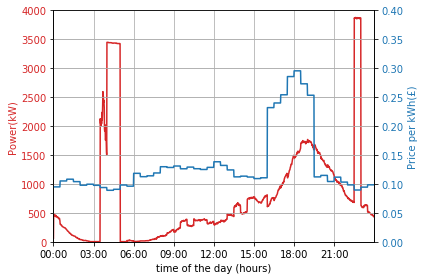

1
3878.27
2
3502.91
3
3336.08
4
2285.84
5
2012.17
6
2007.32
7
2002.86
8
2000.0


In [7]:
#initialise key matrices and vectors
power = np.zeros((1440,len(df)))
energy_delivered = np.zeros(len(df))
minutes_to_charge = np.zeros((1440,len(df)))
initial_no_min_charging = np.zeros(len(df))
power_limit = 2000
total_power_per_minute = np.zeros(1440)

for C in range(len(df)):
#Get the times the vehicle plugs-in and plugs-out in minutes for indexing
    time_in = int(math.ceil(df['Enter'].iloc[C]))
    time_out = int(math.floor(df['Leave'].iloc[C]))
#Calculate the minimum number of required charging minutes
    initial_no_min_charging[C] = math.ceil(round_down(df['charge_needed'].iloc[C],2)/(7/60)-1)
#If the user chooses to prioritise time then the minutes that are required to charge the vehicle are worked out. These are the
#just the minutes between the plug-in and plug-out times in order.
     
    if df['Priority'].iloc[C] == 'Time':
        if time_out > time_in:
            for a in range(time_out-time_in+1):
                minutes_to_charge[a,C] = time_in+a
        elif time_in > time_out:
            for a in range((1440 - time_in) + time_out):
                if a + time_in < 1440:
                    minutes_to_charge[a,C] = a + time_in
                elif a + time_in >= 1440:
                    minutes_to_charge[a,C] = a + time_in - 1440 + 1
#If the user chooses to prioritise coat then the minutes that are required to charge the vehicle are worked out. These are the
#just the cheapest minutes between the plug-in and plug-out times in order.            
    elif df['Priority'].iloc[C] == 'Cost':
        if time_out > time_in:
            sorted_arguments = np.argsort(cost[time_in:time_out+1])
            for b in range(len(sorted_arguments)):
                minutes_to_charge[b,C] = sorted_arguments[b] + time_in 
        elif time_in > time_out:
            
            array1 = cost[time_in:]
            array2 = cost[:time_out+1]
            array3 = np.append(array1,array2)
            sorted_arguments = np.argsort(array3)
            for c in range(len(sorted_arguments)):
                if sorted_arguments[c] + time_in < 1440:
                    minutes_to_charge[c,C] = sorted_arguments[c] + time_in
                elif sorted_arguments[c] + time_in >= 1440:
                    minutes_to_charge[c,C] = sorted_arguments[c] + time_in - 1440 

                
    #print(initial_no_min_charging[C])
    length = int(initial_no_min_charging[C])

#Charging at maximum power for the required minimum number of minutes
    power_max = 7            
    for d in range(length):
        index = int(minutes_to_charge[d,C])
        power[index,C] = power_max
#CHarging up to final desired charge    
    final_index = int(minutes_to_charge[length+1,C])
    power[final_index,C] = (df['charge_needed'].iloc[C] - np.sum(power[:,C])/60)*60  
    energy_delivered[C] = np.sum(power[:,C])/60   
    
for e in range(1440):
    total_power_per_minute[e] = np.sum(power[e,:])
total_power = np.zeros(1440)
#total_power vector scaled to the Graden village
for f in range(1440):
    total_power[f] = np.sum(power[f,:])*2200/(unique_days*unique_users)
        
initial_total_power = total_power_per_minute

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time of the day (hours)')
plt.xticks(np.arange(0,1440,180),('00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','24:00'))
ax1.set_ylabel('Power(kW)', color='tab:red')
plt.ylim(0,4000)
ax1.plot(initial_total_power*2200/(unique_days*unique_users),color = 'tab:red')
plt.grid()
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Price per kWh(£)', color=color)  
plt.ylim(0,0.40)
ax2.plot(cost, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.grid()
plt.xlim(0,1440)
plt.show()

no_min_charging = np.zeros(len(df))
for E in range(len(df)):
    no_min_charging[E] = initial_no_min_charging[E]
#POWER LIMITING SECTION OF THE ALGORITHM   
condition = all(X <= power_limit for X in total_power)
Z = 0
while condition == False:  

#For all minutes where the total power is over the limit the limited power is split between the active chargers
    for f in range(1440):
        if total_power_per_minute[f] > power_limit:
            number_chargers_active = np.count_nonzero(power[f,:])
            new_power_max = power_limit/(2200/(unique_days*unique_users))/number_chargers_active
            for g in range(len(df)):
                if power[f,g] > 0:
                    power[f,g] = new_power_max
                    if np.sum(power[:,g])/60 > df['charge_needed'].iloc[g]:
                        power[f,g] = 0
                        power[f,g] = (df['charge_needed'].iloc[g]-np.sum(power[:,g])/60)*60
                                       
#Using unused minutes to charge the vehicles to their desired level    
    for h in range(len(df)):
        for H in range(1440):
            if np.sum(power[:,h])/60 < df['charge_needed'].iloc[h]:
                index = int(minutes_to_charge[H,h])
                if power[index,h] == 0:
                    power[index,h] = power_max
                    if np.sum(power[:,h])/60 > df['charge_needed'].iloc[h]:
                            power[index,h] = 0
                            power[index,h] = (df['charge_needed'].iloc[h]-np.sum(power[:,h])/60)*60

                
            
        if (np.sum(power[:,h]) < round_down(df['charge_needed'].iloc[h],2)) & (round_down(df['charge_needed'].iloc[h],2) <12.5):
            df['charge_needed'].iloc[h] == np.sum(power[:,h])
            print(df['charge_needed'].iloc[h])            
                
    for i in range(1440):
        total_power_per_minute[i] = int(np.sum(power[i,:]))
    total_power = np.zeros(1440)
    for f in range(1440):
        total_power[f] = round_down(np.sum(power[f,:])*2200/(unique_days*unique_users),2)
    Z = Z+1
    print(Z)
    print(max(total_power))
    condition = all(Y <= 2000 for Y in total_power)

In [8]:
for C in range(len(df)):
    energy_delivered[C] = np.sum(power[:,C])/60   
df['charge_delivered'] = energy_delivered

In [9]:
df.head(60)

,Enter,Leave,Priority,max_deliverable_charge,Initial_charge,energy_desired,charge_needed,charge_delivered
0,620.0,623.0,Time,0.35,12.5,12.85,0.35,0.35
1,641.0,767.0,Time,12.50,12.5,25.00,12.50,12.50
2,674.0,731.0,Time,6.65,12.5,19.14,6.64,6.64
3,18.0,543.0,Cost,12.50,12.5,25.00,12.50,12.50
4,582.0,726.0,Cost,12.50,12.5,25.00,12.50,12.50
5,550.0,724.0,Time,12.50,12.5,25.00,12.50,12.50
6,581.0,636.0,Time,6.41,12.5,18.91,6.41,6.41
7,584.0,747.0,Cost,12.50,12.5,25.00,12.50,12.50
8,3.0,400.0,Time,12.50,12.5,25.00,12.50,12.50
9,1171.0,1.0,Cost,12.50,12.5,25.00,12.50,12.50


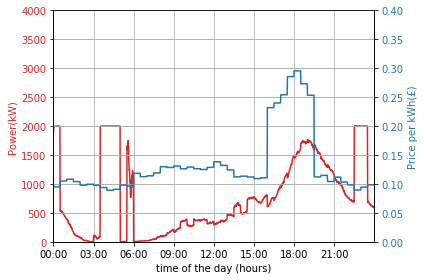

2000.0


In [11]:
total_power = np.zeros(1440)
for f in range(1440):
    total_power[f] = round_down(np.sum(power[f,:])*2200/(unique_days*unique_users),2)
    
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time of the day (hours)')
plt.xticks(np.arange(0,1440,180),('00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','24:00'))
ax1.set_ylabel('Power(kW)', color='tab:red')
plt.ylim(0,4000)
ax1.plot(total_power,color = 'tab:red')
plt.grid()
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Price per kWh(£)', color=color)  
plt.ylim(0,0.40)
ax2.plot(cost, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.grid()
plt.xlim(0,1440)
plt.show()

print(max(total_power))